### Optical pumping control of ammeter, function generator, and lock-in amplifier

PJHT 12/19/19

Uses DS345, SR865A, and HP 34401A.

Connect the DS345 and HP34401A via USB-serial adapters.  The SR865A gets a direct USB cable.  The HP34401 has a specially marked cable that allows the DTR-DSR hardware handshake.

Need to have a vxi-11 or ni-visa installation.  Google it.
Also need to install pyvisa using pip.  Google it.  Probably need to run Anaconda Command window as an Administrator.

Ignores all instruments that are not listed in Devices list

Run the next cell once to find all the instruments

In [1]:
%matplotlib qt
# The following line, 'import visa', raises an error, "AttributeError: module 'visa' has no attribute 'ResourceManager'."
# It needs to be 'import pyvisa as visa' instead.
# This issue is discussed on Github discussion page "https://github.com/pyvisa/pyvisa/issues/392"
#import visa  #here if using usb connection with vxi-11 or ni-visa
import pyvisa as visa

import pyvisa.constants
from pyvisa.constants import StopBits, Parity
import time
from time import sleep
import matplotlib.animation as animation  #for real time display
from numpy import append #need this to gather the data on the fly
from time import sleep, localtime,strftime #some timekeeping functions
#from serial import SerialException
rm = visa.ResourceManager()
print("Here are the resources in use: ")
print(rm.list_resources())
resources = rm.list_resources()

# Here are the device names of the three instruments connected via USB (865A), or USB serial converter:
Devices = ["Stanford_Research_Systems,SR865A","StanfordResearchSystems,DS345","HEWLETT-PACKARD,34401A"]

#Determine which resources are valid by issuing *IDN? query to all devices:
valid_inst =[]
return_list=[]
print("Opening them in turn and asking who they are: ")
for i in resources:
    print("Resource: ",i)
    try:
        res_list = rm.open_resource(i)
        return_str = res_list.query('*IDN?')
        valid_inst.append(i)
        return_list.append(return_str)
    except:
        continue
print("Connected istruments: ", valid_inst)
print(" with names: ",return_list)

#Now determine which resources are used (depending on the order of plugging in the USB cables)
#These routines determine the order in which they are enumerated

indx =[]
for i in return_list:
    for j in range(len(Devices)):
        pos = i.find(Devices[j])
        if pos== 0:
            indx.append(j)
            
print("Index (order in which the names match Devices list):",indx)
#Just go ahead and open in the order to the Devices list, using the indices found above.  These resources
#need to be listed in the order in which they appear in Devices list
AllOK = False
Error = False
try:
    SR865A = rm.open_resource(valid_inst[indx[0]])
    print("SR865A connected!")
except:
    print("     SR865A not connected")
    Error = True
    
try:    
    DS345 = rm.open_resource(valid_inst[indx[1]])
    print("DS345 connected!")
except:    
    print("     DS345 not connected")
    Error = True
try:
    HP34401A = rm.open_resource(valid_inst[indx[2]])
    print("HP34401A connected!")
except:
    print("     HP34401A not connected")
    Error = True
#The HP is elderly, and uses dtr-dsr flow control, so configure it:
if Error==False:
    HP34401A.set_visa_attribute(pyvisa.constants.VI_ATTR_ASRL_FLOW_CNTRL,pyvisa.constants.VI_ASRL_FLOW_DTR_DSR)
    print("All instruments connected")
else:
    print("***Check that all instruments are powered and cabled***")

#If there is no IndexError, this should work
        

Here are the resources in use: 
('ASRL1::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL6::INSTR')
Opening them in turn and asking who they are: 
Resource:  ASRL1::INSTR
Resource:  ASRL3::INSTR
Resource:  ASRL4::INSTR
Resource:  ASRL6::INSTR
Connected istruments:  []
 with names:  []
Index (order in which the names match Devices list): []
     SR865A not connected
     DS345 not connected
     HP34401A not connected
***Check that all instruments are powered and cabled***


### Initialize all instruments
Reads the ammeter

Sets the function generator to some frequency

Reads the Lock-in

In [2]:
print("Reading from the HP ammeter\r\n")
#Note:  the .query method is a combined send/response.  Here we use .write(), for HP system commands because the HP does not return
#anything.  A .query() would wait for a response until the comm link timed out.
HP34401A.write('syst:rem')   #put it in remote
HP34401A.write('*RST')  #reset it
HP34401A.write('*CLS')  #clear errors
HP34401A.write("func 'curr:dc'")   #select DC amps
HP34401A.write('disp:text "Get to work!"')  #write something to the screen. Note that while the ammeter is in remote mode
#it will not show live current readings on the front panel anyway (just press local button to see these)
return_str = HP34401A.query(" meas:curr:dc?")  #Now ask for a current current value, expecting a response

print("HP measure response: ",return_str)  #which is returned as a string of characters

print("Setting the Helmholtzcurrent variable:\r\n")
Helmholtzcurrent = float(return_str)  #float it and store in local variable, to be attached to file name, etc.
print("Helmholtz current is {:8.3e} A\r\n".format(Helmholtzcurrent))

#Here's how you change the frequency of the DS345  (we could have used .query() instead of .write().  The SRS returns
#the number of transmitted characters)
print("Setting DS345 to 8000 Hz\r\n")
return_str = DS345.write("FREQ 8000")

print("Testing the SR865A with a snapshot of X, Y, R, Theta:\r\n")  # This is the default order for all 4 measurements
return_string = SR865A.query("SNAPD?")
print(return_string)   


Reading from the HP ammeter

HP measure response:  +7.77989530E-02

Setting the Helmholtzcurrent variable:

Helmholtz current is 7.780e-02 A

Setting DS345 to 8000 Hz

Testing the SR865A with a snapshot of X, Y, R, Theta:

5.7882407418e-06,-1.1362077203e-05,1.275149134e-05,-63.004108429



### Acquisition Loop

Edit the f1 and f2 frequency ranges to step the SRS DS345 through frequencies

Adjust the SRS DS345 amplitude

Measure the starting current with the HP DMM

Plot the autoscaled live data


## Set frequency windows for scan.  Scans of lower window, then upper window

In [3]:
# lower_freq_1 = 7540000
# upper_freq_1 = 7780000
#lower_freq_2 = 11390000
#upper_freq_2 = 11600000


lower_freq_1 = 400000
upper_freq_1 = 650000
lower_freq_2 = 650000
upper_freq_2 = 1000000



step_freq = 1000

## Run data acquisition

In [21]:
volt_array = []
current_array = []
SR865Astring = "AUXV 1,"  #preamble to auxiliary voltage command
volts = -2.0  #set at 2 V, which should be 48 V maximum ouput voltage on supply.  Remember:  *negative*
valstring = "{:7.3f}".format(volts)
SR865A.write(SR865Astring+valstring)
SR865Astring = "AUXV 0,"
for x in range(20)[::-1]:
    volts = -.1*x  #Remember:  *negative*
    valstring = "{:7.3f}".format(volts)
    SR865A.write(SR865Astring+valstring)
    sleep(0.5)
    return_str = HP34401A.query(" meas:curr:dc?")
    sleep(0.5)
#     print("HP measure response: ",return_str)
    print("{:7.4f}, {:7.4f}".format(volts,float(return_str)))
    volt_array.append(volts)
    current_array.append(float(return_str))


-1.9000,  1.4950
-1.8000,  1.4161
-1.7000,  1.3370
-1.6000,  1.2583
-1.5000,  1.1795
-1.4000,  1.1007
-1.3000,  1.0223
-1.2000,  0.9438
-1.1000,  0.8654
-1.0000,  0.7861
-0.9000,  0.7068
-0.8000,  0.6284
-0.7000,  0.5491
-0.6000,  0.4710
-0.5000,  0.3919
-0.4000,  0.3129
-0.3000,  0.2345
-0.2000,  0.1559
-0.1000,  0.0777
-0.0000, -0.0014


In [10]:
from scipy.stats import linregress
linregress(volt_array,current_array)

LinregressResult(slope=-0.7875534505263155, intercept=0.18225327400000035, rvalue=-0.9999997926720795, pvalue=6.721478208615142e-59, stderr=0.00011953298015378036)

In [7]:
plt.figure()
plt.plot(volt_array,current_array,'r+')

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import time

from numpy import append #need this to gather the data on the fly
from time import sleep, localtime,strftime #some timekeeping functions
#from serial import SerialException  # no longer used with PyVISA
#Support routines to convert the strings to bytes and append the correct <CR> or <LF>
DWELL = 0.5 # Pause (seconds) at each frequency step.  Make this 5 * RC time constant of lock-in
SLEEP_TIME = 0.3
#TIME_OUT = 0.2  # don't hang around forever looking for data, but give srs time.  0.2 s is good

#SRS_BAUD = 9600  #we can raise this rate if the instrument is set correctly.  9600 is srs DS345 default
#HP_BAUD = 9600  #fast as it goes!
#PAR_BAUD = 9600

#PAUSE =.1 #Just in case commands pile up.  Probably not necessary, given DS345's 25-character command buffer
#DATA_LENGTH = 50
# read/write functions

DS345.write("FUNC0 ") #sine wave
DS345.write("AMPL0.1VP ") #0.09 V pp amplitude-- can change this upwards of 0.2 or 0.3 at high field
DS345.write("OFFS0.0 ") #0.0 V offset

freq_list_total =[]
data_list_total=[]
done_flag = 0  #needed to break out of animation loop
count = 0
dataval =0.0
amplval = 0.09 #amplitude of SRS DS345
valstring = "AMPL{:4.3f}VP ".format(amplval)  #set the amplitude

DS345.write(valstring) #0.09 V pp amplitude-- can change this upwards of 0.2 or 0.3 at high field
print("Scanning..")

#Here are typical ranges for 1 Gauss field 
#f1 = np.arange(lower_freq_1,upper_freq_1,step_freq)  #convenient to scan in two chunks, one for each isotope of rubidium
#f2 = np.arange(lower_freq_2,upper_freq_2,step_freq)
#f1 = np.arange(1100000,1200000,500)  #Here for 0.372 A opposing
#f2 = np.arange(1650000,1800000,500)#convenient to scan in two chunks, one for each isotope of rubidium
#f_all = f1
#f2 = arange(6350000,6500000,1000)
#f_all = np.concatenate((f1,f2),0)  # put two scan ranges together

# fvec = np.array(f_all)
# bad_count = 0

# fig = plt.figure()  #open up the live plot
#ax1 = fig.add_subplot(1,1,1)
#xar = []
#yar = []
#ax.plot([start_wavelength,end_wavelength],[0,0])
#ax = plt.axes(xlim=(fvec[0], fvec[-1])) #scaling it to show all frequency data
#ax.relim()
#ax.autoscale_view()
#plt.plot([start_wavelength,end_wavelength],[0,0])

#plt.ylim(-1E-10,1E-8)
# y_max = 1E-9  #start small 
# line, = ax.plot([], [], lw=2)  
# count = 0

# #freq = fvec[count]
# SRSstring = "FREQ "
# valstring = "{:7.3f}".format(freq)  #write the next frequncy
# DS345.write(SRSstring+valstring)
# print(count, SRSstring+valstring)  #show progress
# sleep(DWELL)
# max_count = len(f_all)-1

def init():
    #line.set_data([], [])
    line.set_data(freq_list, data_list)
    return line,

SR865Astring = "AUXV 1,"  #preamble to auxiliary voltage command
volts = -4.0  #set at 2 V, which should be 48 V maximum ouput voltage on supply.  Remember:  *negative*
valstring = "{:7.3f}".format(volts)
SR865A.write(SR865Astring+valstring)

# def animate(i, max_count,done_flag, bad_count, y_max):
#     while (done_flag==0):
#         freq = fvec[i]  #output the next frequency in the list
#         SRSstring = "FREQ "
#         valstring = "{:7.3f}".format(freq)
#         DS345.write(SRSstring+valstring)
#         #print(count, SRSstring+valstring)
#         sleep(DWELL) #one ought to wait 5 RC

#         return_str= SR865A.query("SNAPD?")  #fetch latest data
#         return_list = return_str.split(",")  #chop up the string
#         #print('return_list: ',return_list)
#         dataval = float(return_list[2])  #default order of 865A has this as R, the sqrt of x^2+y^2, which will be
#         #independent of phase.  Convert it.
       

#         data_list.append(dataval)
#         #print(data_list)
#         freq_list.append(freq)
#         ax.relim()
#         ax.autoscale_view()
#         #print('ymax =', y_max)    
#         print("{:7.3f},{:12.9e}".format(freq,dataval), end='\r' )  #Keep on a line
#         line.set_data(freq_list, data_list)    
#         #count+=1 #increment the counter
#         #print("Count, i = ", count, i)
#         if i==max_count:
#             done_flag = 1
#             print("\r\nDone")
#             plt.close(fig) #"Kill the live plot, indicating that you're done
#         return line,            


for x in np.linspace(.2,1,5):
    volts = -x*.1  #Remember:  *negative*
    SR865Astring = "AUXV 0,"
    valstring = "{:7.3f}".format(volts)
    SR865A.write(SR865Astring+valstring)
    sleep(0.5)
    return_str = HP34401A.query(" meas:curr:dc?")
    sleep(0.5)
    print("HP measure response: ",return_str)

    Helmholtzcurrent = float(return_str)
    print("Helmholtz current is {:8.3e} A".format(Helmholtzcurrent))
    #print("Helmholtz current is {:8.3f} A".format(Helmholtzcurrent))
    #Helmholtzcurrent = 1.410
    #data=[]
    data_list =[]
    freq_list=[]
    return_list =[]
    print(float(return_str))
    B_field = -6.48*float(return_str) + 0.275
    factor = abs(B_field)
    print(factor)
    lower_freq_1 = 400000*factor
    upper_freq_1 = 500000*factor
    lower_freq_2 = 650000*factor
    upper_freq_2 = 750000*factor
    
    step_freq = 500
    f1 = np.arange(lower_freq_1,upper_freq_1,step_freq)  #convenient to scan in two chunks, one for each isotope of rubidium
    f2 = np.arange(lower_freq_2,upper_freq_2,step_freq)
    f_all = np.concatenate((f1,f2),0)  # put two scan ranges together
    fvec = np.array(f_all)
    print(fvec)

    for i in range(len(fvec)):
        freq = fvec[i]  #output the next frequency in the list
        SRSstring = "FREQ "
        valstring = "{:7.3f}".format(freq)
        DS345.write(SRSstring+valstring)
        #print(count, SRSstring+valstring)
        sleep(DWELL) #one ought to wait 5 RC

        return_str= SR865A.query("SNAPD?")  #fetch latest data
        return_list = return_str.split(",")  #chop up the string
        #print('return_list: ',return_list)
        dataval = float(return_list[2])  #default order of 865A has this as R, the sqrt of x^2+y^2, which will be
        #independent of phase.  Convert it.
       

        data_list.append(dataval)
        #print(data_list)
        freq_list.append(freq)
        print("Frequenc: ", freq, "Amperage :",dataval)
    data_list_total.append(data_list)
    freq_list_total.append(freq_list)

# ani = animation.FuncAnimation(fig, animate, init_func=init, fargs = [max_count,done_flag, bad_count, y_max],blit=True)
    
# plt.show()


Scanning..
HP measure response:  +1.47368270E-02

Helmholtz current is 1.474e-02 A
0.014736827
0.17950536104000003
[ 71802.144416  72302.144416  72802.144416  73302.144416  73802.144416
  74302.144416  74802.144416  75302.144416  75802.144416  76302.144416
  76802.144416  77302.144416  77802.144416  78302.144416  78802.144416
  79302.144416  79802.144416  80302.144416  80802.144416  81302.144416
  81802.144416  82302.144416  82802.144416  83302.144416  83802.144416
  84302.144416  84802.144416  85302.144416  85802.144416  86302.144416
  86802.144416  87302.144416  87802.144416  88302.144416  88802.144416
  89302.144416 116678.484676 117178.484676 117678.484676 118178.484676
 118678.484676 119178.484676 119678.484676 120178.484676 120678.484676
 121178.484676 121678.484676 122178.484676 122678.484676 123178.484676
 123678.484676 124178.484676 124678.484676 125178.484676 125678.484676
 126178.484676 126678.484676 127178.484676 127678.484676 128178.484676
 128678.484676 129178.484676 1296

In [5]:
%store data_list_total freq_list_total 

Stored 'data_list_total' (list)
Stored 'freq_list_total' (list)


In [65]:
np.linspace(.2,1,5)

array([0.2, 0.4, 0.6, 0.8, 1. ])

In [2]:
import pandas as pd
df = pd.DataFrame(data_list_total)
df2 = pd.DataFrame(freq_list_total)

NameError: name 'data_list_total' is not defined

In [1]:
import pandas as pd
df = pd.read_csv("Amperage.csv")
df2 = pd.read_csv("Frequency.csv")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

current_list = [1.474e-2,3.032e-2,4.654e-2,6.208e-2,7.74e-2]
current_list1 = [-1.616e-03, 7.769e-2, 1.56e-1,2.345e-1,3.129e-1,3.919e-1,4.711e-1,5.492e-1] # Range 0 to 8
peak1_array = []
peak2_array = []
for row in range(len(df)):
    data = df.iloc[row]
    freqs = df2.iloc[row]
    B_field = -6.48*float(current_list1[row]) + 0.275
    factor = abs(B_field)
    lower_freq_1 = 400000*factor
    upper_freq_1 = 500000*factor
    lower_freq_2 = 650000*factor
    upper_freq_2 = 750000*factor
    peak1 = freqs[np.argmax(data[:np.where(freqs > upper_freq_1)[0][0]])]
    peak2 = freqs[np.where(freqs > lower_freq_2)[0][0]+np.argmax(data[np.where(freqs > lower_freq_2)[0][0]:])]
    peak1_array.append(peak1)
    peak2_array.append(peak2)

In [3]:
df = pd.read_csv("Amperage Refined.csv")
df2 = pd.read_csv("Frequency Refined.csv")

In [28]:
peak1_array1 = []
peak2_array1 = []
for row in range(len(df)):
    data = df.iloc[row]
    freqs = df2.iloc[row]
    B_field = -6.48*float(current_list[row]) + 0.275
    factor = abs(B_field)
    lower_freq_1 = 400000*factor
    upper_freq_1 = 500000*factor
    lower_freq_2 = 650000*factor
    upper_freq_2 = 750000*factor
    peak1 = freqs[np.argmax(data[:np.where(freqs > upper_freq_1)[0][0]])]
    peak2 = freqs[np.where(freqs > lower_freq_2)[0][0]+np.argmax(data[np.where(freqs > lower_freq_2)[0][0]:])]
    peak1_array1.append(peak1)
    peak2_array1.append(peak2)

In [18]:
def vfunc(x,a,b,c):
    return a*abs(x + b) 

In [22]:
Rb85freq = np.append(peak1_array, peak1_array1)
Rb87freq = np.append(peak2_array, peak2_array1)
Bfield = np.append(current_list1,current_list)  

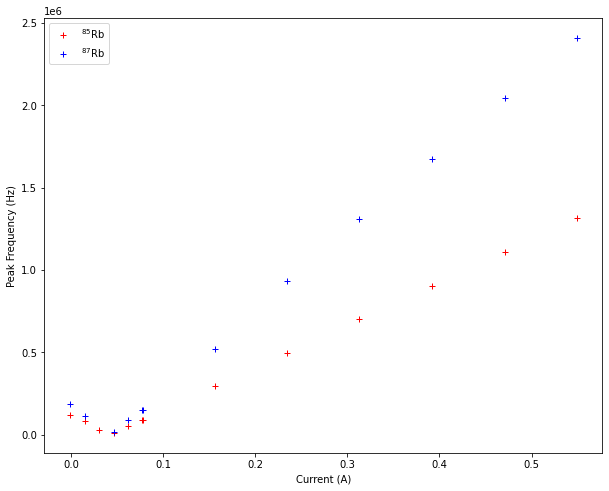

In [27]:
# %matplotlib tk
plt.figure(figsize=(10,8))
current_list = np.array(current_list)
current_list1 = np.array(current_list1)
plt.plot(Bfield,Rb85freq,"r+",label="${}^{85}$Rb")
plt.plot(Bfield,Rb87freq,"b+",label="${}^{87}$Rb")
plt.xlabel("Current (A)")
plt.ylabel("Peak Frequency (Hz)")
plt.legend()
plt.show()

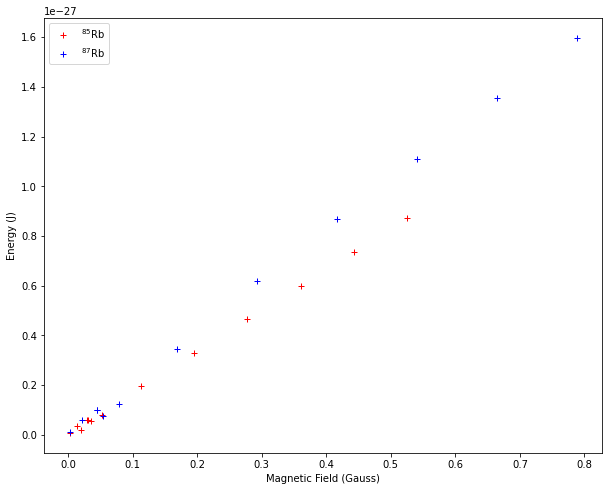

In [63]:
from scipy.constants import Planck, physical_constants

beta_gauss = physical_constants["Bohr magneton"][0]/1e4
plt.figure(figsize=(10,8))
current_list = np.array(current_list)
current_list1 = np.array(current_list1)
plt.plot(abs(funclin(Bfield,*popt))*2/3,Rb85freq*Planck,"r+",label="${}^{85}$Rb")
plt.plot(abs(funclin(Bfield,*popt)),Rb87freq*Planck,"b+",label="${}^{87}$Rb")
# plt.plot(Bfield,Bfield*9.27e-24,label="$\mu_B$")
plt.xlabel("Magnetic Field (Gauss)")
plt.ylabel("Energy (J)")
plt.legend()
plt.show()

In [64]:
beta_gauss

9.274010078300001e-28

In [54]:
linregress(abs(funclin(Bfield,*popt))*2/3,Rb85freq*Planck)


LinregressResult(slope=1.655455040385976e-27, intercept=3.082830348641257e-30, rvalue=0.9997206918401605, pvalue=3.02190499569904e-19, stderr=1.1799642483128148e-29)

In [72]:

linregress(np.delete(abs(funclin(Bfield,*popt)),9),np.delete(Rb87freq*Planck,9))

LinregressResult(slope=2.046664622370102e-27, intercept=-1.5576163147477567e-30, rvalue=0.9994569626980164, pvalue=3.715401677158128e-16, stderr=2.1337987016711402e-29)

In [7]:
df.to_csv("Amperage Refined.csv")
df2.to_csv("Frequency Refined.csv")

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,82,83,84,85,86,87,88,89,90,91
0,0,71802.144416,72302.144416,72802.144416,73302.144416,73802.144416,74302.144416,74802.144416,75302.144416,75802.144416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,31403.872640,31903.872640,32403.872640,32903.872640,33403.872640,33903.872640,34403.872640,34903.872640,35403.872640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,10642.561216,11142.561216,11642.561216,12142.561216,12642.561216,13142.561216,17294.161976,17794.161976,18294.161976,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,50910.678304,51410.678304,51910.678304,52410.678304,52910.678304,53410.678304,53910.678304,54410.678304,54910.678304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,91771.479520,92271.479520,92771.479520,93271.479520,93771.479520,94271.479520,94771.479520,95271.479520,95771.479520,...,167128.65422,167628.65422,168128.65422,168628.65422,169128.65422,169628.65422,170128.65422,170628.65422,171128.65422,171628.65422


### Open up a static plot and save the data in the folder from where Jupyter started
Store the data with a file name that incorporates the date and time, along with the current reading

In [ ]:
def Find_Bfield(Current):
    # The below values are calculated in the process of calibration
    slope = 0.006515
    intercept = -0.215451
    return (slope*Current+intercept)

def Find_Current(Bfield):
    # The below values are calculated in the process of calibration
    slope = 0.006515
    intercept = -0.215451
    return ((Bfield-intercept)/slope)

In [ ]:
Bfield=16
print("Current for {} Gauss is {} mA.".format(Bfield, Find_Current(Bfield)))

In [ ]:
plt.figure()
data = np.array(data_list,float)
freqs = np.array(freq_list,float)
plot_title = 'Optical Pumping I = {:5.4f} A,  Ampl = {:4.3f} VPP, Lock-in Amp. Time constant=300ms'.format(Helmholtzcurrent, amplval)
plt.title(plot_title)
plt.plot(freqs,data, lw=2)

In [14]:
#open up a static plot 

plt.figure()
data = np.array(data_list,float)
freqs = np.array(freq_list,float)
plt.plot(freqs,data, lw=2)

print("1st peak is at {} Hz".format(freqs[np.argmax(data[:np.where(freqs > upper_freq_1)[0][0]])]))
print("2nd peak is at {} Hz".format(freqs[np.where(freqs > lower_freq_2)[0][0]+np.argmax(data[np.where(freqs > lower_freq_2)[0][0]:])]))
plot_title = 'Optical Pumping I = {:5.3f} A, B_field = {:5.3f} Gauss, Ampl = {:4.3f} VPP, Lock-in Amp. Time constant=300ms'.format(Helmholtzcurrent, Find_Bfield(Helmholtzcurrent*1000), amplval)
plt.title(plot_title)
plt.xlabel("Frequency")
plt.ylabel("LockIn output")
plt.text(lower_freq_1,np.max(data),"Peak: {} Hz".format(freqs[np.argmax(data[:np.where(freqs > upper_freq_1)[0][0]])]),size=12)
plt.text(lower_freq_2,np.max(data),"Peak: {} Hz".format(freqs[np.where(freqs > lower_freq_2)[0][0]+np.argmax(data[np.where(freqs > lower_freq_2)[0][0]:])]),size=12)
plt.show()

# Here to save data with unique filename
from time import localtime,strftime #some timekeeping functions
today_str = strftime("%d%m%y_%H.%M",localtime())

filename = "Optical Pumping {:9.5f} A ".format(Helmholtzcurrent)+today_str+".csv"
headertext = 'Optical Pumping I = {:9.7f} A'.format(Helmholtzcurrent)
np.savetxt (filename, np.column_stack((freqs,data,)),delimiter = ",",fmt="%9.5e",header=headertext)



1st peak is at 467000.0 Hz
2nd peak is at 697500.0 Hz


NameError: name 'Find_Bfield' is not defined

# Plot Peak Frequency vs. Magnetic Field

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

PeakFreq_85 = np.array([479500, 716000, 1188500, 950500, 1429500, 1910000, 2384500, 2862500, 3336500, 3813500, 4761500, 5712000, 6649500, 7635000])
PeakFreq_87 = np.array([718500, 1073500, 1782000, 1425500, 2144500, 2868000, 3581000, 4300000, 5012500, 5732000, 7162500, 8599000, 10019000, 11452000])
B_Field = [0.996, 1.496, 2.482, 1.985, 2.987, 3.995, 4.998, 5.989, 6.983, 7.986, 9.981, 11.982, 13.961, 15.960]
plt.title("Peak Frequency vs. Magnetic Field")
plt.xlabel("Magnetic Field(Gauss)")
plt.ylabel("Peak Frequency(Hz)")
plt.plot(B_Field, PeakFreq_85, label="85Rb", marker='s')
plt.plot(B_Field, PeakFreq_87, label="87Rb", marker='^')
slope, intercept, r_value, p_value, std_err = stats.linregress(B_Field, PeakFreq_85)
plt.text(10, 4*10**6,"85Rb->slope:{0:.2f},intercept:{1:.2f}".format(slope,intercept),size=12)
slope, intercept, r_value, p_value, std_err = stats.linregress(B_Field, PeakFreq_87)
plt.text(8, 1*10**7,"87Rb->slope:{0:.2f},intercept:{1:.2f}".format(slope,intercept),size=12)
plt.legend()

In [ ]:
plt.plot(B_Field, PeakFreq_85, label="85Rb", marker='s')
plt.plot(B_Field, PeakFreq_87/1.5, label="87Rb/1.5", marker='x')
plt.legend()

#### Under development. Scan the magnetic field at fixed RF frequency.  Use the SR865A to send out an Aux 0 voltage to program the HP 6555A power supply current.  Also need an AUX 1 voltage to program the power supply voltage

### Note:  the programming voltages must be isolated from the load.  This means that you must not ground either connector to the Helmholtz coils, no matter how tempting it is to use the big ground stud on the power supply.

Connections:  AUX OUT 1 goes to 1st contact on connector block.  Ground goes to 5th contact on connector block.  SR865A supplies a negative programming voltage such that -5 V = 3A from the power supply.  The approximate conversion is then

-1 mV from SR865A should produce (1 mV)(4A/5V) = 0.8 mA

In order for this to work, you need to program a voltage in the same way:  AUX OUT 2 goes to 2nd contact on HP 6555A connector block, and ground goes to 5th contact.  Again, you supply up to -5V which should correspond to 120 V.  The approximate conversion is then

-1 mV from SR565A should produce (1 mV)(120V/5V) = 24 mV

The Helmholtz coils have a resistance of about 20 ohms, so in order to get the full 3A (caution: coils will get warm) we need to supply about 60 V.  Thus the AUX OUT 2 should set for around (60 V/24 mV) = 2500 mV, or -2.5 V.  To be safe, set it to -1V and see where the front panel switches from CC to CV, indicating Control Current (desired), rather than Control Voltage (undesired, subject to vagaries of Joule heating of the coil).

The display will not show the current or voltage--you'll need to read the current with a separate ammeter.  If the display shows Unr ("Unregulated") it probably means that you have grounded one of the output connections.  Don't!

In [ ]:
return_string = SR865A.query("SNAPD?")
print(return_string)
#First attempt to write -1 V out from SR865A
return_string = SR865A.write("AUXV 0, -1.00")
print(return_string)
    

In [ ]:
#Ramp up then down on SR865A AUX 0 
import matplotlib.pyplot as plt
import numpy as np
SR865Astring = "AUXV 1,"  #preamble to auxiliary voltage command
volts = -3.0  #set at 2 V, which should be 48 V maximum ouput voltage on supply.  Remember:  *negative*
valstring = "{:7.3f}".format(volts)
SR865A.write(SR865Astring+valstring)
sleep(5)
#Now scan the current up, then down

SR865Astring = "AUXV 0,"
currentReading=[]
progVolts = []    
gauss=[]
for i in range(20):
    volts = -i*0.1  #Remember:  *negative*
    progVolts.append(volts)
    valstring = "{:7.3f}".format(volts)
    SR865A.write(SR865Astring+valstring)
    #now try reading the AUX 1 input value from Bartington
    sleep(0.2)  #allow to settle both current and B field readings   
    #Here we should take 5 or so readings to get an average
    N = 10
    sumI = 0.0
    sumB = 0.0
    for i in range(N):
        return_str= SR865A.query("OAUX? 0")  #fetch voltage data from AUX IN Channel 1.  This is the magnetometer reading
        Bval = float(return_str)
        return_str = HP34401A.query(" meas:curr:dc?")  #measure the current
        Ival = float(return_str)
        print(i, Ival, Bval)
        sumI = sumI+Ival
        sumB = sumB+Bval
        sleep(0.1)
    gauss.append(sumB/N)
    currentReading.append(sumI/N)
    print(sumI/N,sumB/N)
for i in reversed(range(10)):    
    volts = -i*0.1  #Remember:  *negative*
    valstring = "{:7.3f}".format(volts)
    SR865A.write(SR865Astring+valstring)    
    sleep(1)
 #as always, if the display shows CV rather than CC, you need to raise the programming voltage. 
plt.figure()
plt.title("B -field in gauss vs. coil current")
plt.plot(currentReading,gauss, '*b')

In [ ]:
fh = open("data.txt","w")
for index in range(len(currentReading)):
    fh.write(f"{currentReading[index]}, {gauss[index]}\n")
fh.close()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.title("B -field in gauss vs. current programming voltage")
plt.plot(progVolts,gauss, '*b')

###  Calibration of B field from Bartington magnetometer

popt:  [ 0.07689389 -1.57525501]
perr:  [inf inf]


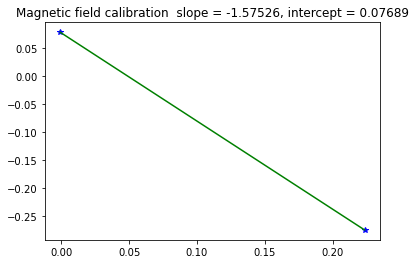

In [34]:
from scipy.optimize import curve_fit
x = current
y = volts
p0 = np.array([0,  1])  #initial guess

def funclin(x,b,m):   
    return m*x+b  
popt, pcov = curve_fit(funclin, x, y,p0)  #fit
perr = np.sqrt(np.diag(pcov))

print("popt: ",popt)
print("perr: ",perr)
plt.figure()
plt.title("Magnetic field calibration  slope = {:7.5f}, intercept = {:7.5f}".format(popt[1],popt[0]))
plt.plot(x,y,'*b')
plt.plot(x, funclin(x,*popt), '-g')

In [33]:
GaussMeter = pd.read_csv("data.txt",header=None)
current = GaussMeter.iloc[0]
volts = GaussMeter.iloc[1]

linregress(current,volts)

LinregressResult(slope=-1.5752550124214884, intercept=0.07689389340829542, rvalue=-1.0, pvalue=0.0, stderr=0.0)